In [124]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [43]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [101]:
# Load CSV file
csv_path = 'archive\dogs.csv'
df = pd.read_csv(csv_path)
selected_breeds = ['Afghan','Border Collie','Corgi', 'Coyote','Doberman', 'German Sheperd', 'Labradoodle','Maltese', 'Pomeranian','Pug','Rottweiler', 'Saint Bernard','Shiba Inu','Shih-Tzu', 'Siberian Husky']

train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

train_df = train_df[train_df['labels'].isin(selected_breeds)]
valid_df = valid_df[valid_df['labels'].isin(selected_breeds)]
test_df = test_df[test_df['labels'].isin(selected_breeds)]

In [45]:
train_df

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train
...,...,...,...
7782,train/Siberian Husky/75.jpg,Siberian Husky,train
7783,train/Siberian Husky/76.jpg,Siberian Husky,train
7784,train/Siberian Husky/77.jpg,Siberian Husky,train
7785,train/Siberian Husky/78.jpg,Siberian Husky,train


In [125]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

img_size = (299, 299)
batch_size = 32

# Define additional data augmentation parameters
def contrast_stretching(x):
    return exposure.rescale_intensity(x, in_range=(0, 1), out_range=(-0.5, 1.5))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,             # Added rotation augmentation
    width_shift_range=0.2,         # Added width shift augmentation
    height_shift_range=0.2,        # Added height shift augmentation
    brightness_range=[0.5, 1.5],   # Added brightness augmentation
    # preprocessing_function=contrast_stretching  # Added contrast augmentation
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 1728 validated image filenames belonging to 15 classes.
Found 150 validated image filenames belonging to 15 classes.
Found 150 validated image filenames belonging to 15 classes.


In [54]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(selected_breeds), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [55]:
from tensorflow.keras.optimizers import Adam, schedules

learning_rate_schedule = schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=learning_rate_schedule)


In [56]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [66]:
# history = model.fit(train_generator, epochs=100, validation_data=valid_generator, callbacks=[early_stopping])

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    callbacks=[early_stopping],
    epochs=20
)


Epoch 1/20
54/54 [==============================] - 24s 444ms/step - loss: 0.1234 - accuracy: 0.9641 - val_loss: 0.6117 - val_accuracy: 0.8800
Epoch 2/20
54/54 [==============================] - 24s 433ms/step - loss: 0.1491 - accuracy: 0.9508 - val_loss: 1.2612 - val_accuracy: 0.7600
Epoch 3/20
54/54 [==============================] - 23s 427ms/step - loss: 0.1877 - accuracy: 0.9468 - val_loss: 0.6190 - val_accuracy: 0.8733
Epoch 4/20
54/54 [==============================] - 23s 427ms/step - loss: 0.1055 - accuracy: 0.9664 - val_loss: 2.5407 - val_accuracy: 0.6667
Epoch 5/20
54/54 [==============================] - 22s 398ms/step - loss: 0.2309 - accuracy: 0.9282 - val_loss: 0.4318 - val_accuracy: 0.8867
Epoch 6/20
54/54 [==============================] - 24s 434ms/step - loss: 0.1284 - accuracy: 0.9572 - val_loss: 0.4951 - val_accuracy: 0.8667
Epoch 7/20
54/54 [==============================] - 23s 417ms/step - loss: 0.1092 - accuracy: 0.9624 - val_loss: 0.7932 - val_accuracy: 0.8267

In [68]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

5/5 [==============================] - 1s 82ms/step - loss: 0.2357 - accuracy: 0.9333
Test Accuracy: 0.9333333373069763


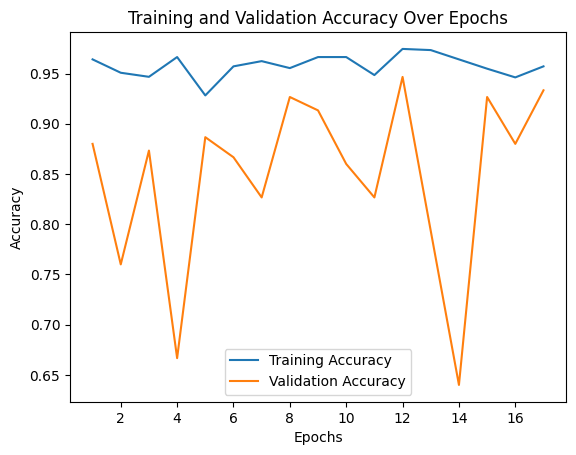

In [69]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy over epochs
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
model.save("dog_breed_inception_model(3).h5")

In [126]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np 

model = load_model('dog_breed_inception_model(3).h5')
img_path = 'archive\\test\Afghan\\01.jpg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = model.predict(img_array)


1/1 [==============================] - 1s 876ms/step


In [127]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = train_generator.class_indices
predicted_class_label = [k for k, v in class_labels.items() if v == predicted_class_index][0]
print(predicted_class_label)

1/1 [==============================] - 0s 25ms/step


Corgi


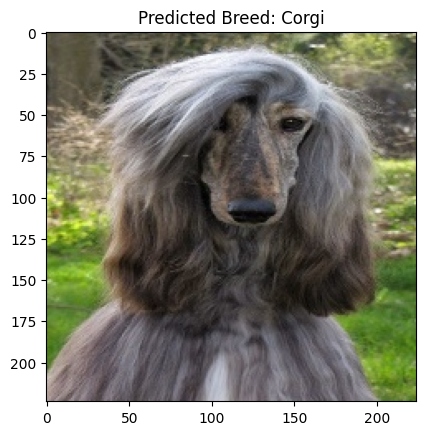

In [128]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f'Predicted Breed: {predicted_class_label}')
plt.show()

In [111]:

def decode_predictions_inception(predictions, top=5, class_labels=None):
    if class_labels is None:
        raise ValueError("class_labels must be provided.")

    # Get the indices of the top predictions
    top_indices = np.argsort(predictions)[0, ::-1][:top]

    # Get the corresponding labels and scores
    top_predictions = [(class_labels[i], predictions[0, i]) for i in top_indices]

    return top_predictions

# Example usage:
predictions = model.predict(img_array)  # Assuming you have a model loaded
class_labels = ['Afghan', 'Border Collie', 'Corgi', 'Coyote', 'Doberman', 'German Sheperd', 'Labradoodle',
                'Maltese', 'Pomeranian', 'Pug', 'Rottweiler', 'Saint Bernard', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky']
decoded_predictions = decode_predictions_inception(predictions, top=3, class_labels=class_labels)

# Print the top predictions
for label, score in decoded_predictions:
    print(f"{label}: {score:.4f}")


1/1 [==============================] - 0s 23ms/step
Corgi: 1.0000
Pomeranian: 0.0000
Siberian Husky: 0.0000


1/1 [==============================] - 0s 23ms/step
1: Corgi (1.00)
2: Pomeranian (0.00)
3: Siberian Husky (0.00)


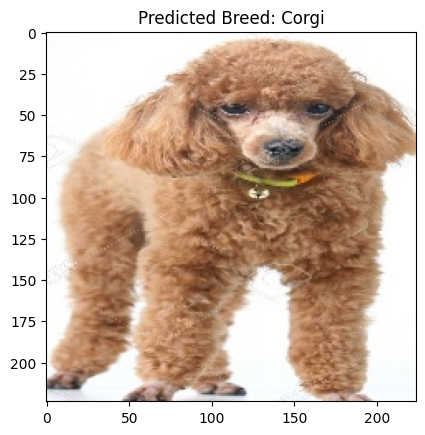

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming you have predictions from your InceptionV3 model
predictions = model.predict(img_array)

# Decode predictions using InceptionV3's decode_predictions
decoded_predictions = decode_predictions_inception(predictions, top=3, class_labels=class_labels)

# Sort predictions by score in descending order
decoded_predictions.sort(key=lambda x: x[1], reverse=True)

# Display the top predictions
for i, (label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

# Display the image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f'Predicted Breed: {decoded_predictions[0][0]}')
plt.show()


ImportError: cannot import name 'string_int_label_map_pb2' from 'object_detection.protos' (c:\Users\rukun\miniconda3\envs\tf\lib\site-packages\object_detection\protos\__init__.py)